# Finite Element Analysis of a Concrete Dam under earthquake loading

Filippo Gatti (filippo.gatti@centralesupelec.fr)

### Set-up

Install `conda` environment: 
- `conda create --name st7 python=3.9 -y`

Activate `conda` environment:
- `conda activate st7`

Verify `conda`-wise `pip`install: 
- `which pip` `echo $CONDA_PREFIX`

Install `jupyter`: 
- `conda install -c anaconda jupyter`

Install packages:
- `conda install numpy`
- `conda install -c anaconda cython`
- `conda install -c conda-forge matplotlib`
- `conda install -c conda-forge scipy`
- `conda install nodejs`
- `conda install -c conda-forge pyvista`
- `pip install gmsh`
- `pip install mgmetis`

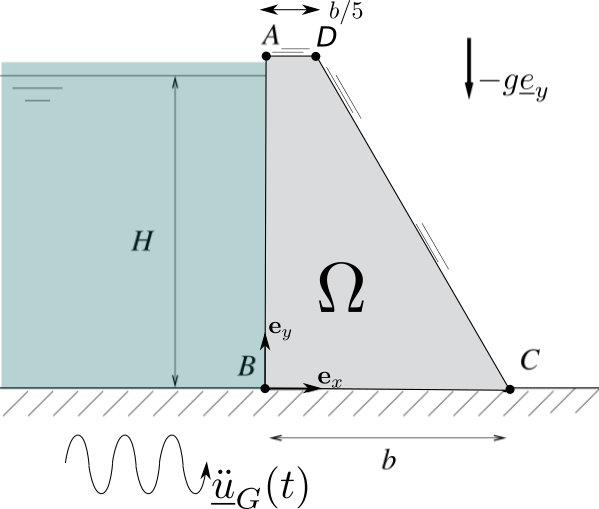

In [1]:
from IPython import display
display.Image("./dam_new.png")

## MESHER

In [4]:
%matplotlib inline
import sys

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.tri as tri

import numpy as np
from scipy.spatial import KDTree

# to install mgmetis
! pip install mgmetis 
from mgmetis import metis

# to install gmsh
! pip install gmsh 
import gmsh

# to install pyvista
! pip install pyvista 
import pyvista as pv
from pyvista.core.utilities import helpers

Defaulting to user installation because normal site-packages is not writeable
  Using cached mgmetis-0.1.1.tar.gz (381 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [8 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Joao Pedro\AppData\Local\Temp\pip-install-4p0rclzk\mgmetis_61855dd619214547a01b1f0518b657c2\setup.py", line 5, in <module>
      import conf
    File "C:\Users\Joao Pedro\AppData\Local\Temp\pip-install-4p0rclzk\mgmetis_61855dd619214547a01b1f0518b657c2\conf.py", line 7, in <module>
      from Cython.Build import cythonize
  ModuleNotFoundError: No module named 'Cython'
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

[notice] A new release of

ModuleNotFoundError: No module named 'mgmetis'

# Troubleshooting if installed with conda
#### Create the two following symbolic links

``sudo mkdir -p /usr/lib/dri``

``sudo ln -s /usr/lib/x86_64-linux-gnu/dri/swrast_dri.so /usr/lib/dri/``

``ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.32 ~/.local/anaconda3/envs/st7/lib/python3.12/site-ackages/zmq/backend/cython/../../../../.././libstdc++.so.6``


__IMPORTANT__: activate the following line to display interactive images on `MyDocker`

In [3]:
# Activate if running on MyDocker
pv.start_xvfb()
from pyvista import set_plot_theme
set_plot_theme("document")

In [4]:
# Set up images
pv.global_theme.background = 'lightgrey'
pv.global_theme.edge_color="black"
pv.global_theme.font.family="arial"
pv.global_theme.font.fmt="%.1f"
pv.global_theme.jupyter_backend="static"
pv.global_theme.font.label_size=30
pv.global_theme.font.color='black'
pv.global_theme.notebook=True
pv.global_theme.axes.show = True
pv.global_theme.window_size = [400, 500]

tol = 1e-6 # overall tolerance

---
---
## Problem set-up
---
---

### Triangular cross section $\Omega\subset\mathbb{R}^{n_d}$:
- $n_d$ = 2
- height $H=30 m$ 
- base $b=10 m$        

In [5]:
ndim = 2  # dimension of the problem
b = 10.0 # base [m]
H = 30.0 # height [m]
xB = 0.0 # x-origin of the reference system (point B)
yB = 0.0 # y-origin of the reference system (point B)

---

## Generate mesh

Tutorial GMSH `t1`: https://gitlab.onelab.info/gmsh/gmsh/blob/gmsh_4_7_1/tutorial/python/t1.py#L15


Tutorial GMSH `t2`: https://gitlab.onelab.info/gmsh/gmsh/blob/gmsh_4_7_1/tutorial/python/t6.py

In [6]:
"""
0. Initialize gmsh
""" 
gmsh.initialize()
gmsh.model.add("DamFEA")


"""
1. Create Geometry
"""

## 1.0 Geometry definition
elsize = 1

# nodesXline = [2,2,2,2] # two-element mesh
# nodesXline = [3,3,3,3] # coarse mesh
nodesXline = [5,5,5,5] # fine mesh
# nodesXline = [30,10,30,10] # finer mesh

## 1.1 Points
# - the first 3 arguments are the point coordinates (x, y, z)
# - the next (optional) argument is the target mesh size close to the point
# - the last (optional) argument is the point tag (a stricly positive integer 
# that uniquely identifies the point)
pA = gmsh.model.geo.addPoint(xB     , yB+H   , 0, elsize, 1) # A
pB = gmsh.model.geo.addPoint(xB     , yB     , 0, elsize, 2) # B
pC = gmsh.model.geo.addPoint(xB+b   , yB     , 0, elsize, 3) # C
pD = gmsh.model.geo.addPoint(xB+b/5., yB+H   , 0, elsize, 4) # D
p5 = gmsh.model.geo.addPoint(xB     , yB+H/2., 0, elsize, 5) # extra node E
p6 = gmsh.model.geo.addPoint(xB+b/2., yB     , 0, elsize, 6) # extra node F
p7 = gmsh.model.geo.addPoint(xB+b/2., yB+H/2., 0, elsize, 7) # extra node G
# If the tag is not provided explicitly, a new tag is automatically created, and
# returned by the function
# The distribution of the mesh element sizes will be obtained by interpolation
# of these mesh sizes throughout the geometry.

## 1.2 Curves

### 1.2.1 Lines
# In the commands below, for example, the line 1 starts at point 1 and ends at
# point 2.
lAB = gmsh.model.geo.addLine(pA, pB, 1) # line AB
lBC = gmsh.model.geo.addLine(pB, pC, 2) # line BC
lCD = gmsh.model.geo.addLine(pC, pD, 3) # line CD
lDA = gmsh.model.geo.addLine(pD, pA, 4) # line DA
# Note that curve tags (last optional argument of addLine) are separate from point tags - hence we can reuse tag `1'
# for our first curve. And as a general rule, elementary entity tags in Gmsh
# have to be unique per geometrical dimension.

### 1.2.2 Line Loop
# A curve loop is defined by an ordered list of connected curves,
# a sign being associated with each curve (depending on the orientation of the
# curve to form a loop). 
# The API function to create curve loops takes a list
# of integers as first argument, and the curve loop tag (which must be unique
# amongst curve loops) as the second (optional) argument:
ll1 = gmsh.model.geo.addCurveLoop([lAB, lBC, lCD, lDA], 1)

## 1.3 Surfaces
# The third elementary entity is the surface. 
# In order to define a simple # rectangular surface from the four curves defined above,
# a curve loop has first to be defined. 

### 1.3.1 Plane surface
# We can then define the surface as a list of curve loops:
ps1 = gmsh.model.geo.addPlaneSurface([ll1], 5) 


"""
2. Mesh size/structure constraints
"""
## 2.1 Seeds on mesh sides
# The `setTransfiniteCurve()' meshing constraints explicitly specifies the
# location of the nodes on the curve. For example, the following command forces
# nodesXline uniformly placed nodes on each curve (including the nodes on the two end
# points):
gmsh.model.geo.mesh.setTransfiniteCurve(lAB, nodesXline[0]) # nodes per line AB
gmsh.model.geo.mesh.setTransfiniteCurve(lBC, nodesXline[1]) # nodes per line BC
gmsh.model.geo.mesh.setTransfiniteCurve(lCD, nodesXline[2]) # nodes per line CD
gmsh.model.geo.mesh.setTransfiniteCurve(lDA, nodesXline[3]) # nodes per line DA

## 2.2 Structured grid
# The `setTransfiniteSurface()' meshing constraint uses a transfinite
# interpolation algorithm in the parametric plane of the surface to connect the
# nodes on the boundary using a structured grid. If the surface has more than 4
# corner points, the corners of the transfinite interpolation have to be
# specified by hand:
gmsh.model.geo.mesh.setTransfiniteSurface(ps1, "Omega", [1, 2, 3, 4])
gmsh.model.geo.mesh.setRecombine(2, 1)
"""
3. Create physical groups (Boundaries, surfaces etc)
"""
# Before they can be meshed (and, more generally, before they can be used by API
# functions outside of the built-in CAD kernel functions), the CAD entities must
# be synchronized with the Gmsh model, which will create the relevant Gmsh data
# structures. This is achieved by the gmsh.model.geo.synchronize() API call for
# the built-in CAD kernel.
gmsh.model.geo.synchronize()
# Synchronizations can be called at any time, but they
# involve a non trivial amount of processing; so while you could synchronize the
# internal CAD data after every CAD command, it is usually better to minimize
# the number of synchronization points.


gmsh.model.addPhysicalGroup(1, [lAB], 100) # AB 
gmsh.model.addPhysicalGroup(1, [lBC], 200) # BC
gmsh.model.addPhysicalGroup(1, [lCD], 300) # CD
gmsh.model.addPhysicalGroup(1, [lDA], 400) # DA
pgs1 = gmsh.model.addPhysicalGroup(2, [ps1], 500)
gmsh.model.setPhysicalName(ndim, pgs1, "Omega")

"""
4. Generate Mesh
"""
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(ndim)
meshfile = "DamMesh.msh"
gmsh.write(meshfile)
gmsh.finalize()

"""
5. Read and Plot Mesh
"""
# read the data
mesh = pv.UnstructuredGrid(meshfile)
edges = mesh.extract_all_edges()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000252523s, CPU 0.000206s)
Info    : Meshing 2D...
Info    : Meshing surface 5 (Transfinite)
Info    : Done meshing 2D (Wall 0.000153076s, CPU 0.000374s)
Info    : 28 nodes 55 elements
Info    : Writing 'DamMesh.msh'...
Info    : Done writing 'DamMesh.msh'



### TODO: Refine the mesh by changing the list `nodesXline`

### Parse mesh

In [7]:
# Inspect mesh structure
print("Mesh nodes: {:>d}".format(mesh.n_points)) # Inspect how many points are in this mesh
print("Mesh cells: {:>d}".format(mesh.n_cells)) # Inspect how many cells are in this mesh
print("Mesh edges: {:>d}".format(edges.n_cells)) # Inspect how many cells are in this mesh
print("Mesh bounds: \n min(x):{0} m - max(x): {1} m - min(y): {2} m max(y): {3}m".format(*tuple(mesh.bounds[:-2]))) # What are the mesh bounds?
print("Mesh geometric center of gravity \n x:{0} m y:{1} m z:{2} m".format(*tuple(mesh.center))) # Hm, where is the center of this mesh?

Mesh nodes: 25
Mesh cells: 48
Mesh edges: 56
Mesh bounds: 
 min(x):0.0 m - max(x): 10.0 m - min(y): 0.0 m max(y): 30.0m
Mesh geometric center of gravity 
 x:5.0 m y:15.0 m z:0.0 m


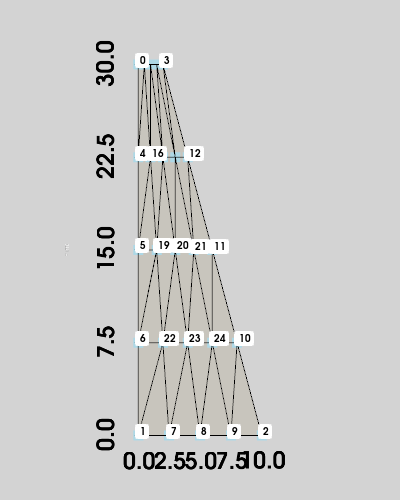

In [8]:
# Plot mesh
plotter = pv.Plotter()
# labels = ["{:>d}".format(l) for l in np.indices((mesh.n_points,))[0].tolist()]
labels = np.indices((mesh.n_points,))[0].astype(np.int64) #.tolist()
plotter.add_mesh(mesh,
                 show_edges=False,
                 scalar_bar_args={'vertical': True},
                 color="white")

points = mesh.points
points = pv.PolyData(points)
points["labels"]=labels.tolist()

# Optional: uncomment the following block to plot node labels

plotter.add_point_scalar_labels(points,'labels',
                                point_size=10,
                                font_size=10,
                                shape_color='white',
                                fill_shape=True,
                                always_visible=True,
                                fmt=r"%.0f",
                                text_color='black',
                               )
plotter.add_mesh(edges,line_width=0.1, color='k')
plotter.show_bounds(xtitle="X [m]",ytitle="Y [m]",ticks="outside")
plotter.show(cpos="xy",interactive_update=True)

In [9]:
n_nodes = mesh.n_points
ndofs = ndim*n_nodes # number of degrees of freedom

# Mesh nodes
node_xyz = mesh.points.astype(np.float64) # numpy array
# Cell tags (from gmsh)
# 3: 2D lines
# 5: 2D triangles
cell_tag = {3:"LIN",5:"CST"}
connectivity_list = [v for _,v in mesh.cells_dict.items()]

# pg = mesh.cell_arrays["gmsh:physical"] # OLD VERSION
pg = mesh.cell_data["gmsh:physical"]
# pg = mesh.celltypes
connectivity_dict = {}
c = 0
for k,v in mesh.cells_dict.items():
    connectivity_dict[cell_tag[k]] = [[e,pg[e]] for e in range(c,c+v.shape[0])]
    c += v.shape[0]
print("\nMesh nodes:\n \n{}".format(node_xyz))
print("\nMesh connectivity list:\n \n{}".format(connectivity_list))
print("\nMesh connectivity dictionary:\n \n{}".format(connectivity_dict))


Mesh nodes:
 
[[ 0.  30.   0. ]
 [ 0.   0.   0. ]
 [10.   0.   0. ]
 [ 2.  30.   0. ]
 [ 0.  22.5  0. ]
 [ 0.  15.   0. ]
 [ 0.   7.5  0. ]
 [ 2.5  0.   0. ]
 [ 5.   0.   0. ]
 [ 7.5  0.   0. ]
 [ 8.   7.5  0. ]
 [ 6.  15.   0. ]
 [ 4.  22.5  0. ]
 [ 1.5 30.   0. ]
 [ 1.  30.   0. ]
 [ 0.5 30.   0. ]
 [ 1.  22.5  0. ]
 [ 2.  22.5  0. ]
 [ 3.  22.5  0. ]
 [ 1.5 15.   0. ]
 [ 3.  15.   0. ]
 [ 4.5 15.   0. ]
 [ 2.   7.5  0. ]
 [ 4.   7.5  0. ]
 [ 6.   7.5  0. ]]

Mesh connectivity list:
 
[array([[ 0,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  1],
       [ 1,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9,  2],
       [ 2, 10],
       [10, 11],
       [11, 12],
       [12,  3],
       [ 3, 13],
       [13, 14],
       [14, 15],
       [15,  0]]), array([[ 0,  4, 15],
       [15,  4, 16],
       [15, 16, 14],
       [14, 16, 17],
       [14, 17, 13],
       [13, 17, 18],
       [13, 18,  3],
       [ 3, 18, 12],
       [ 4,  5, 16],
       [16,  5, 19],
       [16, 19, 17],
 

### Partition mesh

In [10]:
n_mpi_processes = 2

_, cell_partition, node_partition = metis.part_mesh_dual(n_mpi_processes,
    [list(vertices) for edges in connectivity_list for vertices in list(edges)])

mesh["cell_partition"] = cell_partition # assign mesh partition to cells
mesh["node_partition"] = node_partition # assign mesh partition to cells
print("Cell partitions \n {}".format(mesh["cell_partition"]))
print("Node partitions \n {}".format(mesh[ "node_partition"]))

Cell partitions 
 [0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1
 1 1 1 0 1 1 1 1 1 1 1]
Node partitions 
 [0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1]


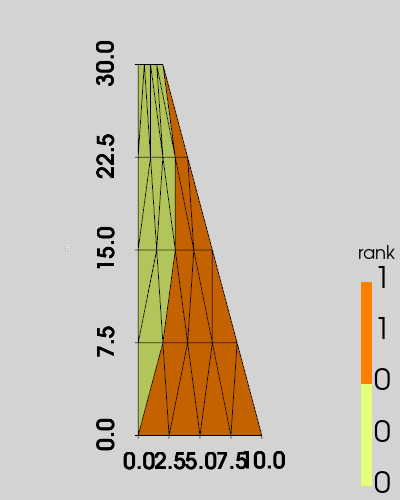

In [11]:
# Plot partitioned mesh element-wise
plotter = pv.Plotter()
plotter.add_mesh(mesh,
                 scalars=mesh["cell_partition"],
                 component=0,
                 show_edges=False,
                 cmap="Wistia",
                 categories=True,
                 scalar_bar_args={'vertical': True, 
                                  'fmt': "%1.0f",
                                  'title': "rank"},
                 color="lightblue")
plotter.add_mesh(edges, line_width=0.01, color='k')
plotter.show_bounds(xtitle="X [m]", ytitle="Y [m]", ticks="outside")

# Optional: uncomment the following block to plot node labels

# plotter.add_point_scalar_labels(points,'labels',
#                                 point_size=10, 
#                                 font_size=10,
#                                 fmt=r"%.0f",
#                                 bold=False,
#                                 text_color='black',
#                                 fill_shape=True,
#                                 shape_color='white',
#                                )

plotter.show(cpos="xy", interactive_update=True)

Courtesy of: Magoulés, F.; Roux, F.-X.; Houzeaux, G. Parallel Scientific Computing; John Wiley & Sons, Inc: Hoboken, NJ, 2016.


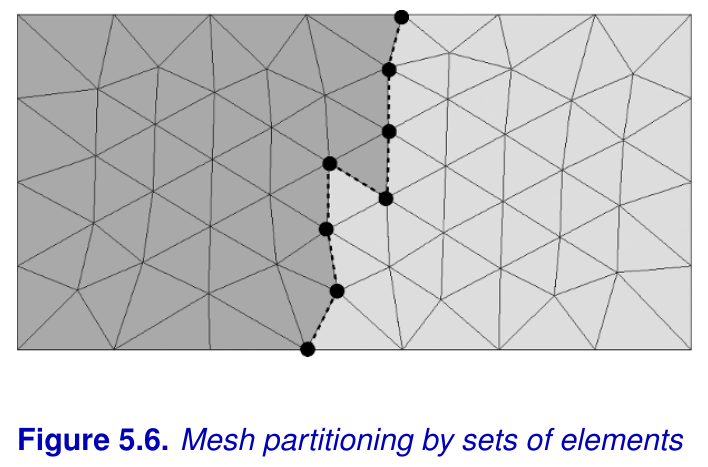

In [12]:
print('Courtesy of: Magoulés, F.; Roux, F.-X.; Houzeaux, G. Parallel Scientific Computing; John Wiley & Sons, Inc: Hoboken, NJ, 2016.')
display.Image("./mesh_partition_by_elements_Magoules_Roux.png")

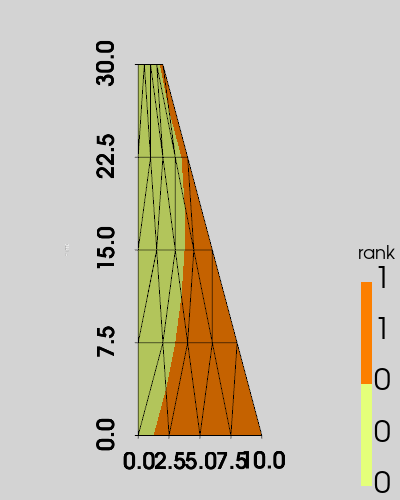

In [13]:
# Plot partitioned mesh element-wise
plotter = pv.Plotter()
plotter.add_mesh(mesh,
                 scalars=mesh["node_partition"].reshape(-1,1),
                 component=0,
                 show_edges=False,
                 cmap="Wistia",
                 categories=True,
                 scalar_bar_args={'vertical': True, 
                                  'fmt': "%1.0f",
                                  'title': "rank"},
                 color="lightblue")
plotter.add_mesh(edges, line_width=0.01, color='k')
plotter.show_bounds(xtitle="X [m]", ytitle="Y [m]", ticks="outside")
plotter.show(cpos="xy", interactive_update=True)

# Optional: uncomment the following block to plot node labels

# plotter.add_point_scalar_labels(points,'labels',
#     point_size=10, 
#     font_size=20,
#     fmt='%d',
#     bold=False,text_color='black',fill_shape=True,shape_color='white',
# )

Courtesy of: Magoulés, F.; Roux, F.-X.; Houzeaux, G. Parallel Scientific Computing; John Wiley & Sons, Inc: Hoboken, NJ, 2016.


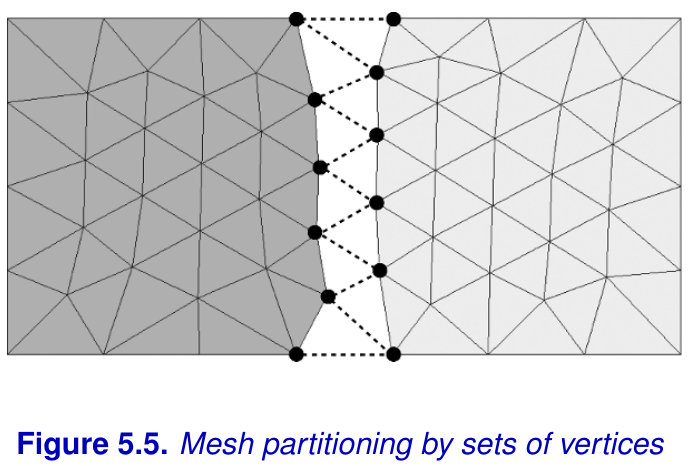

In [14]:
print('Courtesy of: Magoulés, F.; Roux, F.-X.; Houzeaux, G. Parallel Scientific Computing; John Wiley & Sons, Inc: Hoboken, NJ, 2016.')
display.Image("./mesh_partition_by_vertices_Magoules_Roux.png")

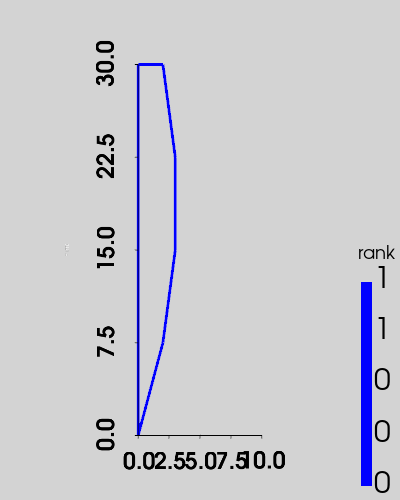

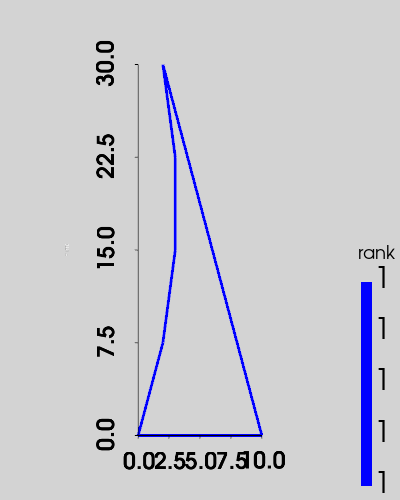

In [15]:
smesh1 = mesh.extract_cells(np.argwhere(mesh["cell_partition"]==0))
smesh2 = mesh.extract_cells(np.argwhere(mesh["cell_partition"]==1))
sedges1 = smesh1.extract_feature_edges(boundary_edges=True,
                                       manifold_edges=False,
                                       feature_edges=False,
                                       non_manifold_edges=False)
sedges2 = smesh2.extract_feature_edges(boundary_edges=True,
                                       manifold_edges=False,
                                       feature_edges=False,
                                       non_manifold_edges=False)
plotter = pv.Plotter()
plotter.add_mesh(sedges1,
                 line_width=3.0,
                 scalars=sedges1["cell_partition"],
                 component=0,
                 show_edges=False,
                 cmap="bwr",
                 categories=True,
                 scalar_bar_args={'vertical': True, 
                                  'fmt': "%1.0f",
                                  'title': "rank"},
                 color="lightblue")
plotter.show_bounds(bounds=mesh.bounds, xtitle="X [m]", ytitle="Y [m]", ticks="outside")
plotter.show(cpos="xy",interactive_update=True)

plotter = pv.Plotter()
plotter.add_mesh(sedges2,
                 line_width=3.0,
                 scalars=sedges2["cell_partition"],
                 component=0,
                 show_edges=False,
                 cmap="bwr",
                 categories=True,
                 scalar_bar_args={'vertical': True, 
                                  'fmt': "%1.0f",
                                  'title': "rank"},
                 color="lightblue")
plotter.show_bounds(bounds=mesh.bounds, xtitle="X [m]", ytitle="Y [m]", ticks="outside")
plotter.show(cpos="xy",interactive_update=True)

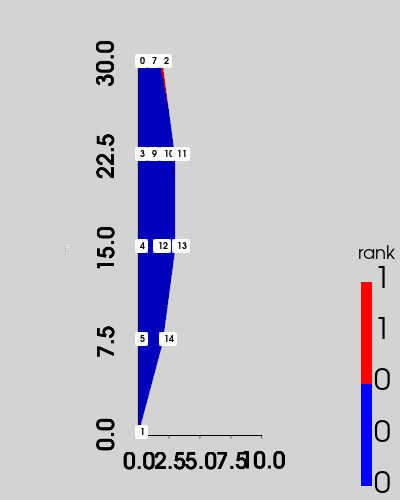

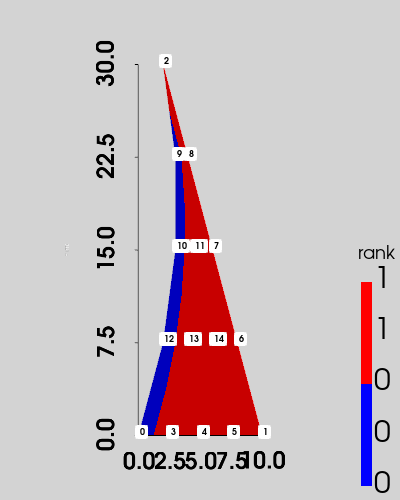

In [16]:
edges2_in_smesh1 = smesh1.select_enclosed_points(sedges2)
edges1_in_smesh2 = smesh2.select_enclosed_points(sedges1)
# mask = selection.point_arrays['SelectedPoints'].view(np.bool_)

plotter = pv.Plotter()
plotter.add_mesh(edges2_in_smesh1,
                 scalars=edges2_in_smesh1["SelectedPoints"],
                 component=0,
                 show_edges=False,
                 cmap="bwr",
                 categories=True,
                 scalar_bar_args={'vertical': True, 
                                  'fmt': "%1.0f",
                                  'title': "rank"},
                 color="lightblue")
points = edges2_in_smesh1.points
points = pv.PolyData(points)
labels = np.indices((edges2_in_smesh1.n_points,))[0].astype(np.int64) #.tolist()
points["labels"]=labels.tolist()
plotter.add_point_scalar_labels(points,'labels',
        point_size=4,
        font_size=9,
        fmt='%.0f',text_color='black',fill_shape=True,shape_color='white',
    )
plotter.show_bounds(bounds=mesh.bounds, xtitle="X [m]", ytitle="Y [m]", ticks="outside")
plotter.show(cpos="xy",interactive_update=True)


plotter = pv.Plotter()
plotter.add_mesh(edges1_in_smesh2,
                 scalars=edges1_in_smesh2["SelectedPoints"],
                 component=1,
                 show_edges=False,
                 cmap="bwr",
                 categories=True,
                 scalar_bar_args={'vertical': True, 
                                  'fmt': "%1.0f",
                                  'title': "rank"},
                 color="lightblue")
points = edges1_in_smesh2.points
points = pv.PolyData(points)
labels = np.indices((edges1_in_smesh2.n_points,))[0].astype(np.int64) #.tolist()
points["labels"]=labels.tolist()
plotter.add_point_scalar_labels(points,'labels',
        point_size=4,
        font_size=9,
        fmt='%.0f',text_color='black',fill_shape=True,shape_color='white',
    )
plotter.show_bounds(bounds=mesh.bounds, xtitle="X [m]", ytitle="Y [m]", ticks="outside")
plotter.show(cpos="xy",interactive_update=True)

In [17]:
edges2_in_smesh1.save("mesh_cpu{:d}.vtk".format(0))
edges1_in_smesh2.save("mesh_cpu{:d}.vtk".format(1))

### TODO: Try to partition with `n_mpi_processes = 4`

### BIBLIOGRAPHY

_Magoulés, F.; Roux, F.-X.; Houzeaux, G. Parallel Scientific Computing; John Wiley & Sons, Inc: Hoboken, NJ, 2016._